In [1]:
# https://colab.research.google.com/github/Machine-Learning-Tokyo/ELSI-DL-Bootcamp/blob/master/data_visualization.ipynb#scrollTo=6OIr_vUxpbS0

from glob import glob
from itertools import product
from noise import add_noise, decompress_pickle
import mat73
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from training_sktime import normalizing, format_dataframe
from sklearn.metrics import accuracy_score
import pickle
MODEL_PATH = './models/new_dataset/'
INPUT_DATA_PATH = '../input-data/'

In [2]:
signal = 'i'
cycle = 'cycle_1'

X_train_flavio = decompress_pickle(INPUT_DATA_PATH + f'folds/{signal}/{cycle}/X_train')
y_train_flavio = decompress_pickle(INPUT_DATA_PATH + f'folds/{signal}/{cycle}/y_train')
X_val_flavio = decompress_pickle(INPUT_DATA_PATH + f'folds/{signal}/{cycle}/X_val')
y_val_flavio = decompress_pickle(INPUT_DATA_PATH + f'folds/{signal}/{cycle}/y_val')

X_train_robson = decompress_pickle(INPUT_DATA_PATH + f'folds-robson/{signal}/{cycle}/X_train')
y_train_robson = decompress_pickle(INPUT_DATA_PATH + f'folds-robson/{signal}/{cycle}/y_train')
X_val_robson = decompress_pickle(INPUT_DATA_PATH + f'folds-robson/{signal}/{cycle}/X_val')
y_val_robson = decompress_pickle(INPUT_DATA_PATH + f'folds-robson/{signal}/{cycle}/y_val')

X_train = pd.concat([X_train_flavio, X_train_robson]).reset_index(drop=True)
y_train = np.concatenate([y_train_flavio, y_train_robson])
X_val = pd.concat([X_val_flavio, X_val_robson]).reset_index(drop=True)
y_val = np.concatenate([y_val_flavio, y_val_robson])

In [3]:
from  sktime.transformations.panel.reduce import Tabularizer

t= Tabularizer()

In [4]:
X_train_flavio = t.fit_transform(X_train_flavio)
X_train_robson = t.fit_transform(X_train_robson)
X_train = t.fit_transform(X_train)
feat_cols = list(X_train_flavio.columns)

In [6]:
hue_order = ['AT', 'BT', 'CT', 'AB', 'BC', 'CA', 'ABT', 'BCT', 'CAT', 'ABC']

In [7]:
X_train_flavio['y'] = y_train_flavio
X_train_robson['y'] = y_train_robson
X_train['y'] = y_train

In [8]:
def replace_with_dict(ar, dic):
    # Extract out keys and values
    k = np.array(list(dic.keys()))
    v = np.array(list(dic.values()))

    # Get argsort indices
    sidx = k.argsort()

    # Drop the magic bomb with searchsorted to get the corresponding
    # places for a in keys (using sorter since a is not necessarily sorted).
    # Then trace it back to original order with indexing into sidx
    # Finally index into values for desired output.
    return v[sidx[np.searchsorted(k,ar,sorter=sidx)]]

classes = dict(zip(np.unique(y_train_flavio), range(10)))
y_train_flavio = replace_with_dict(y_train_flavio, classes)
y_train_robson = replace_with_dict(y_train_robson, classes)
y_train = replace_with_dict(y_train, classes)

In [9]:
X_train_flavio['numeric_label'] = y_train_flavio
X_train_robson['numeric_label'] = y_train_robson
X_train['numeric_label'] = y_train

In [10]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
import time


In [11]:
np.random.seed(42)
rndperm_flavio = np.random.permutation(X_train_flavio.index)
rndperm_robson = np.random.permutation(X_train_robson.index)
rndperm = np.random.permutation(X_train.index)

In [12]:
pca = PCA(n_components=6)
pca_result = pca.fit_transform(X_train_flavio[feat_cols].values)

# # add new columns to our dataFrame: pca-one, pca-two, pca-three
# df['pca-one'] = pca_result[:,0]
# df['pca-two'] = pca_result[:,1] 
# df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.38346463 0.20327771 0.14235287 0.12142965 0.06702014 0.0349272 ]


In [13]:
pca.explained_variance_ratio_.sum()

0.9524722028461472

In [14]:
X_train_flavio_subset = X_train_flavio.loc[rndperm_flavio,:].copy()
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_train_flavio_subset[feat_cols].values)
X_train_flavio_subset['pca-one'] = pca_result[:,0]
X_train_flavio_subset['pca-two'] = pca_result[:,1] 
X_train_flavio_subset['pca-three'] = pca_result[:,2]
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 752 samples in 0.001s...
[t-SNE] Computed neighbors for 752 samples in 0.027s...
[t-SNE] Computed conditional probabilities for sample 752 / 752
[t-SNE] Mean sigma: 347.788021
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.919300
[t-SNE] KL divergence after 300 iterations: 0.457541
t-SNE done! Time elapsed: 0.9926836490631104 seconds


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

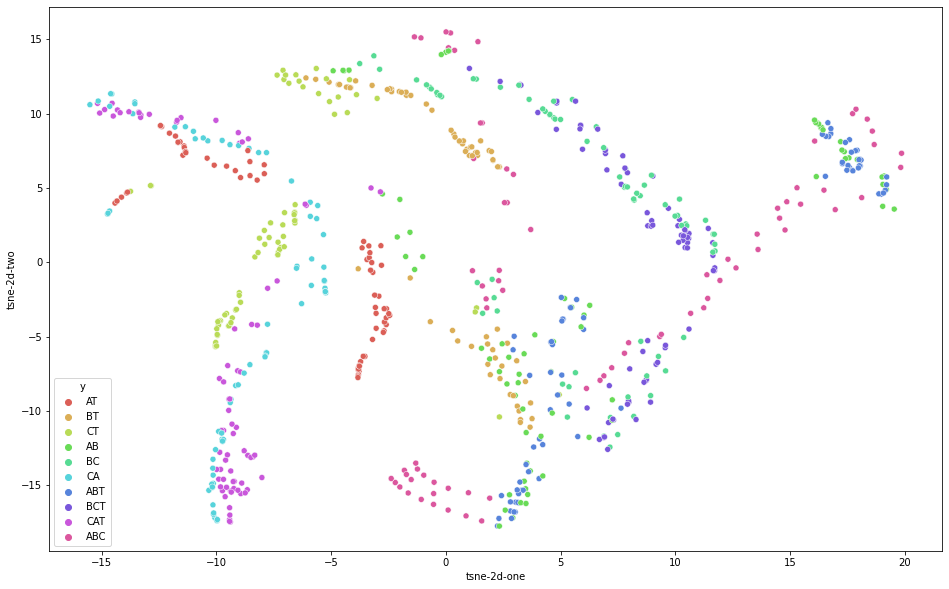

In [16]:
X_train_flavio_subset['tsne-2d-one'] = tsne_results[:,0]
X_train_flavio_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=X_train_flavio_subset,
    legend="full",
    alpha=1.0,
    hue_order=hue_order,
)

In [24]:
# X_train_flavio_subset = X_train_flavio.loc[rndperm_flavio,:].copy()
# pca = PCA(n_components=6)
# pca_result = pca.fit_transform(X_train_flavio_subset[feat_cols].values)
# time_start = time.time()
# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
# tsne_results = tsne.fit_transform(X_train_flavio_subset.iloc[:, :-4].values)
# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 752 samples in 0.001s...
[t-SNE] Computed neighbors for 752 samples in 0.452s...
[t-SNE] Computed conditional probabilities for sample 752 / 752
[t-SNE] Mean sigma: 5502.616832
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.014790
[t-SNE] KL divergence after 500 iterations: 0.387087
t-SNE done! Time elapsed: 2.1791462898254395 seconds


In [32]:
X_train_flavio_subset = X_train_flavio.loc[rndperm_flavio,:].copy()
pca = PCA(n_components=6)
pca_result = pca.fit_transform(X_train_flavio_subset[feat_cols].values)
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(pca_result)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 752 samples in 0.017s...
[t-SNE] Computed neighbors for 752 samples in 0.103s...
[t-SNE] Computed conditional probabilities for sample 752 / 752
[t-SNE] Mean sigma: 1174.530332
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.339581
[t-SNE] KL divergence after 500 iterations: 0.385196
t-SNE done! Time elapsed: 1.5051441192626953 seconds


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

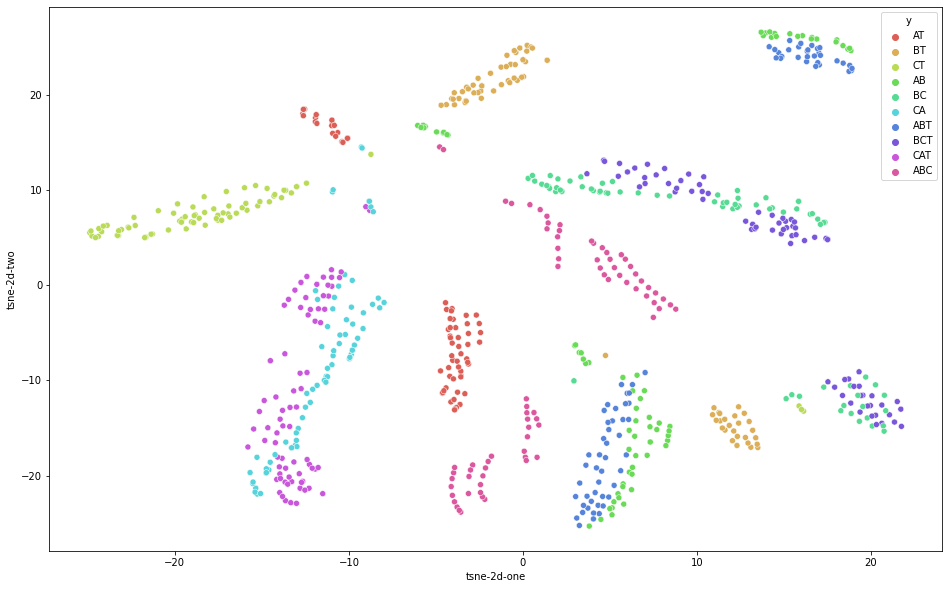

In [33]:
X_train_flavio_subset['tsne-2d-one'] = tsne_results[:,0]
X_train_flavio_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=X_train_flavio_subset,
    legend="full",
    alpha=1.0,
    hue_order=hue_order,
)

In [28]:
X_train_robson_subset = X_train_robson.loc[rndperm_robson,:].copy()
pca = PCA(n_components=6)
pca_result = pca.fit_transform(X_train_robson_subset[feat_cols].values)
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(pca_result)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 752 samples in 0.003s...
[t-SNE] Computed neighbors for 752 samples in 0.107s...
[t-SNE] Computed conditional probabilities for sample 752 / 752
[t-SNE] Mean sigma: 24.440848
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.371750
[t-SNE] KL divergence after 500 iterations: 0.751064
t-SNE done! Time elapsed: 2.095802068710327 seconds


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

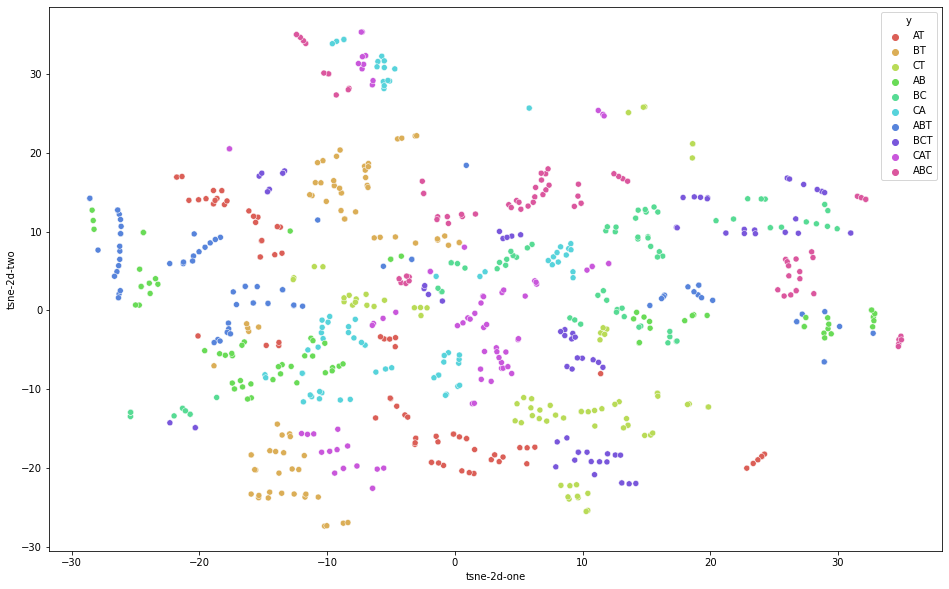

In [29]:
X_train_robson_subset['tsne-2d-one'] = tsne_results[:,0]
X_train_robson_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=X_train_robson_subset,
    legend="full",
    alpha=1.0,
    hue_order=hue_order,
)

In [ ]:
X_train_flavio_subset['tsne-2d-one'] = tsne_results[:,0]
X_train_flavio_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=X_train_flavio_subset,
    legend="full",
    alpha=1.0
)

In [30]:
X_train_subset = X_train.loc[rndperm,:].copy()
pca = PCA(n_components=6)
pca_result = pca.fit_transform(X_train_subset[feat_cols].values)
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(pca_result)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1504 samples in 0.002s...
[t-SNE] Computed neighbors for 1504 samples in 0.135s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1504
[t-SNE] Computed conditional probabilities for sample 1504 / 1504
[t-SNE] Mean sigma: 23.817601
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.850220
[t-SNE] KL divergence after 500 iterations: 0.798570
t-SNE done! Time elapsed: 4.299738168716431 seconds


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

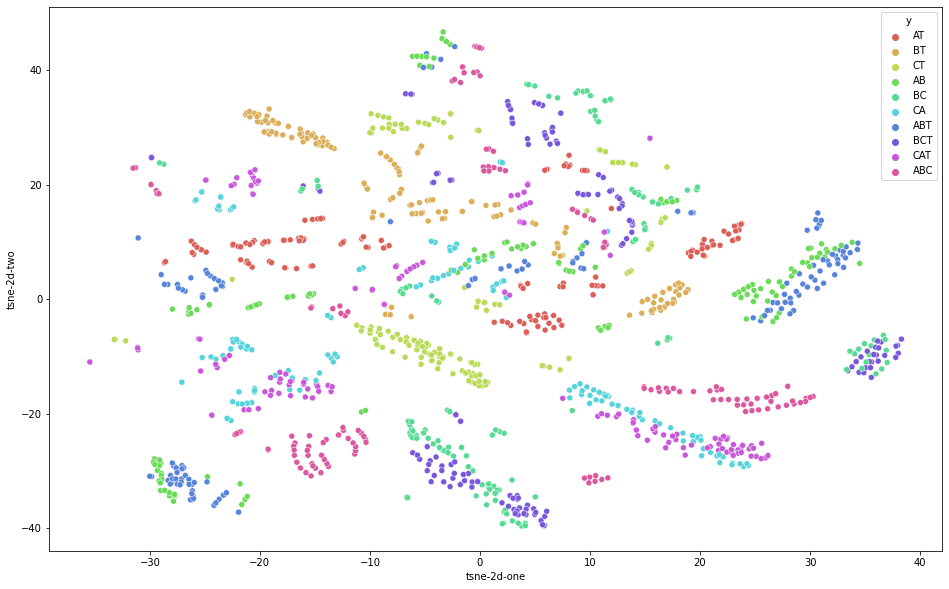

In [31]:
X_train_subset['tsne-2d-one'] = tsne_results[:,0]
X_train_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=X_train_subset,
    legend="full",
    alpha=1.0,
    hue_order=hue_order,
)